## **MMCCI Melanoma Integration and Analysis Example**

In this example, we have melanoma samples from three different technologies - Visium, CosMX and Xenium.
Each sample has been run through stLearn CCI and the outputs are saved as `.h5ad` files.

We will integrate the samples together, and then run analysis on the integrated results.

### **Integration**

These CCI results will be integrated together in this notebook with the following steps:
1. Load the stLearn outputs and convert to be used with MMCCI
2. Integrate by technology (Visium, CosMX, Xenium)
3. Integrate within each patient (4 different patients)

\
Note: This notebook took <2 mins to run and used <500MB of memory

In [2]:
import multimodal_cci as mmcci

#### 1. Load stLearn outputs

This data is available on the GitHub repo and includes the `adata.uns['per_lr_cci_cell_type]` for each sample, as well as the number of spots for each sample

In [3]:
import pickle

with open('../data/melanoma_data.pkl', 'rb') as f:
    melanoma_data = pickle.load(f)

In [4]:
# These colours will be used for plotting later

from matplotlib import pyplot as plt

colors = {
    'Endothelial': plt.colormaps.get_cmap('tab20').colors[0],
    'Fibroblast': plt.colormaps.get_cmap('tab20').colors[1],
    'KC Differentiating': plt.colormaps.get_cmap('tab20').colors[2],
    'KC Cycling': plt.colormaps.get_cmap('tab20').colors[3],
    'KC Basal': plt.colormaps.get_cmap('tab20').colors[4],
    'KC Other': plt.colormaps.get_cmap('tab20').colors[5],
    'NK + T': plt.colormaps.get_cmap('tab20').colors[6],
    'B + PDC': plt.colormaps.get_cmap('tab20').colors[7],
    'Melanocyte': plt.colormaps.get_cmap('tab20').colors[8],
    'Myeloid': plt.colormaps.get_cmap('tab20').colors[9],
    'Pilosebaceous': plt.colormaps.get_cmap('tab20').colors[10]
}

Some of the celltype names are slightly different between technologies, so we can fix that with this function

In [6]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}

visium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['visium_cci']]
cosmx_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['cosmx_cci']]
xenium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['xenium_cci']]

#### 2. Integrate by technology

This step first normalises the samples based on the number of spots

In [7]:
visium_normalised = mmcci.it.normalise_within_tech(visium_cci, melanoma_data['visium_sizes'])
xenium_normalised = mmcci.it.normalise_within_tech(xenium_cci, melanoma_data['xenium_sizes'])
cosmx_normalised = mmcci.it.normalise_within_tech(cosmx_cci, melanoma_data['cosmx_sizes'])

Next, we integrate all the samples within each technology and plot a network plot for each one

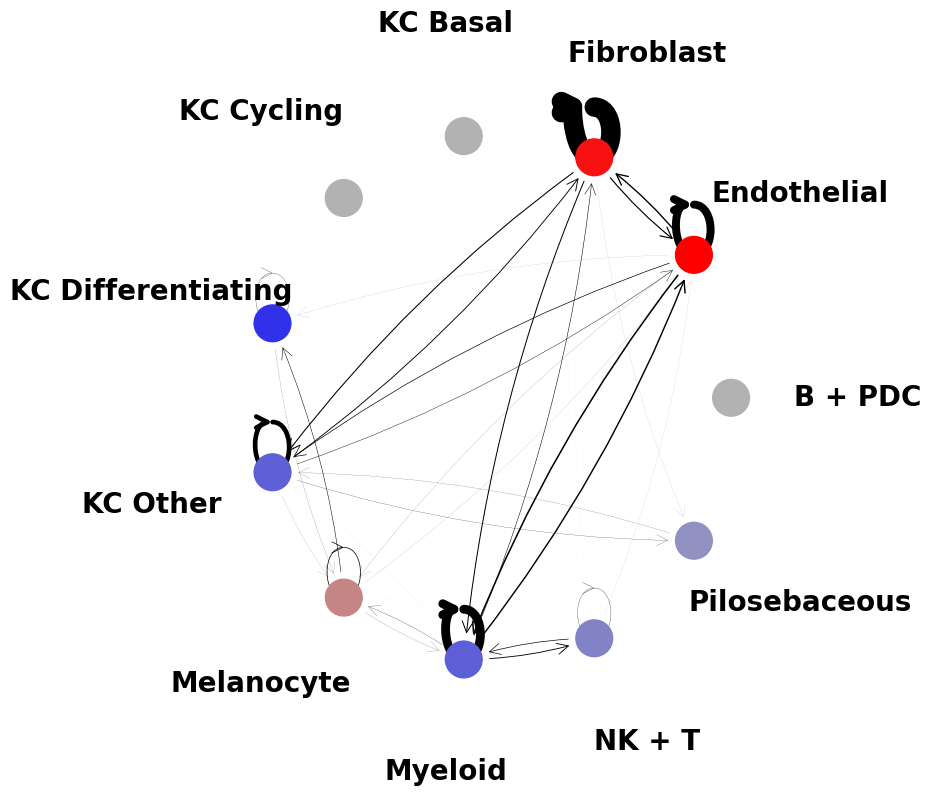

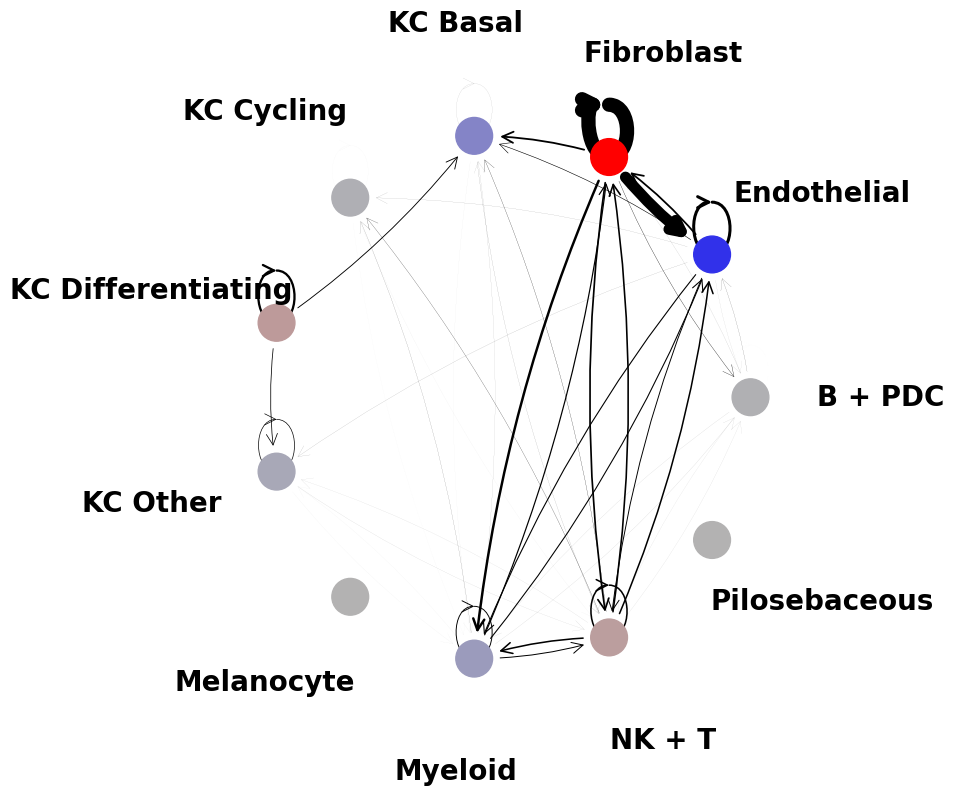

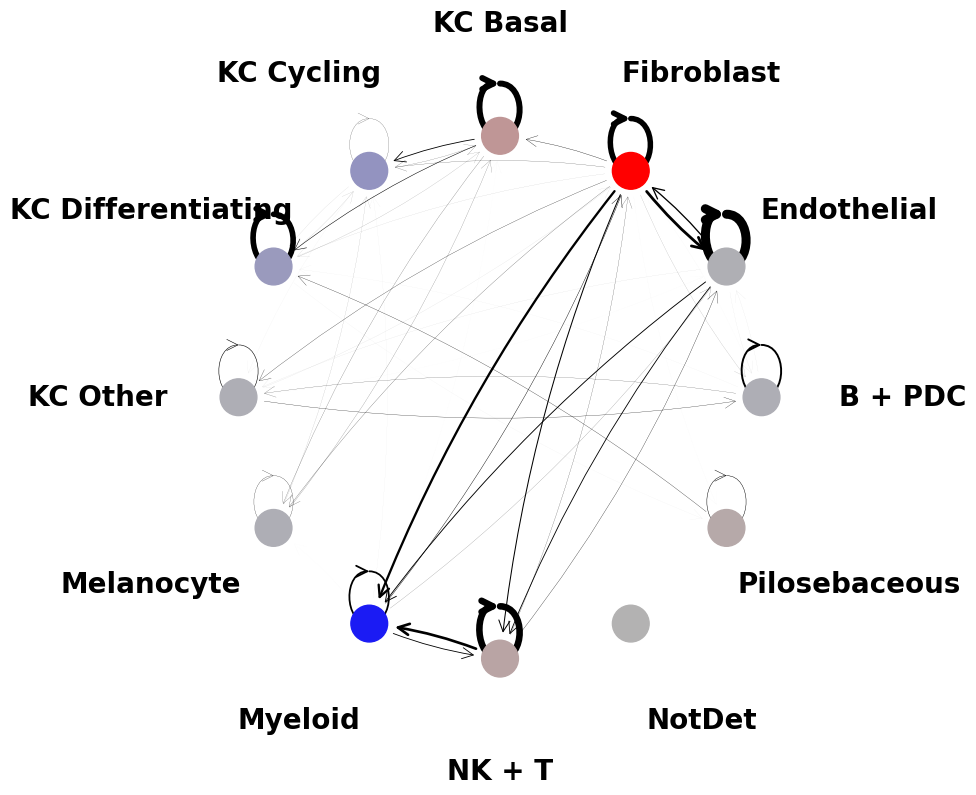

In [12]:
integrated_tech = {}
overall = {}

for tech, samples in zip(['vis', 'xen', 'cos'], [visium_normalised, xenium_normalised, cosmx_normalised]):
    integrated_tech[tech] = mmcci.it.integrate_samples(samples)
    overall[tech] = mmcci.it.calculate_overall_interactions(integrated_tech[tech])
    mmcci.plt.network_plot(overall[tech], edge_weight=40, text_size=20, node_label_dist=1.1)

Finally, we can integrate each of these together to get a complete integrated network

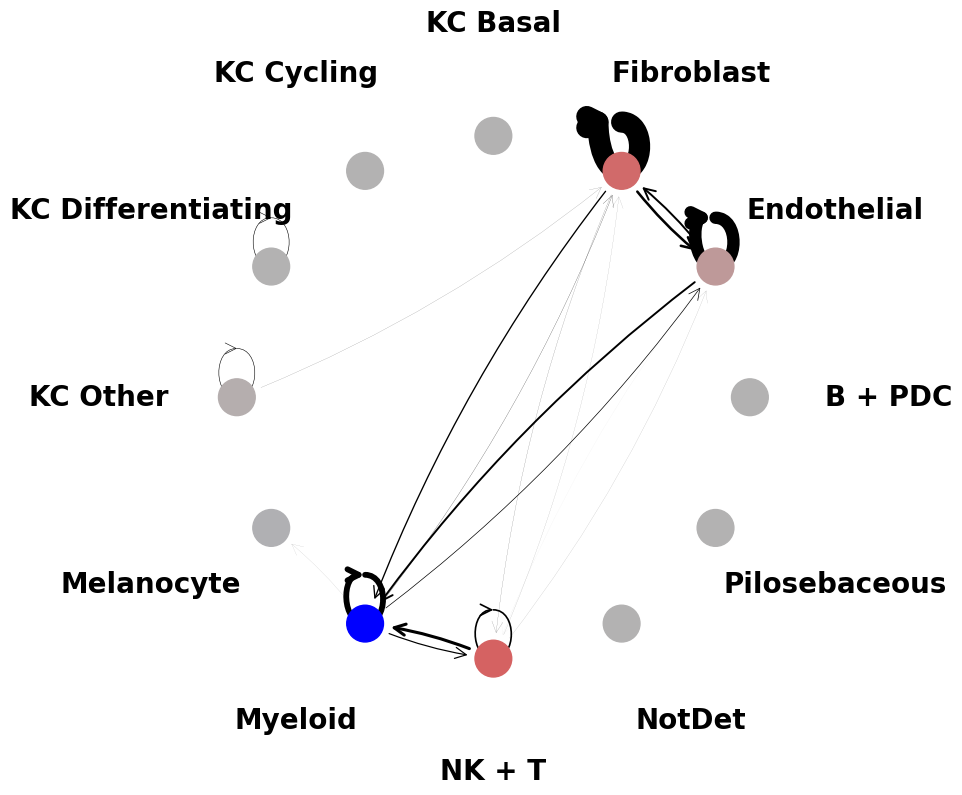

In [13]:
normalised = mmcci.it.normalise_between_tech(
    [integrated_tech['vis'], integrated_tech['xen'], integrated_tech['cos']]
    )

integrated = mmcci.it.integrate_samples(normalised)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.network_plot(overall, edge_weight=40, text_size=20, node_label_dist=1.1)

#### 3. Integrate wibythin patient

We use the same normalised CCI results as before but integrate by patient now

In [14]:
# Define the samples that each patient has

p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

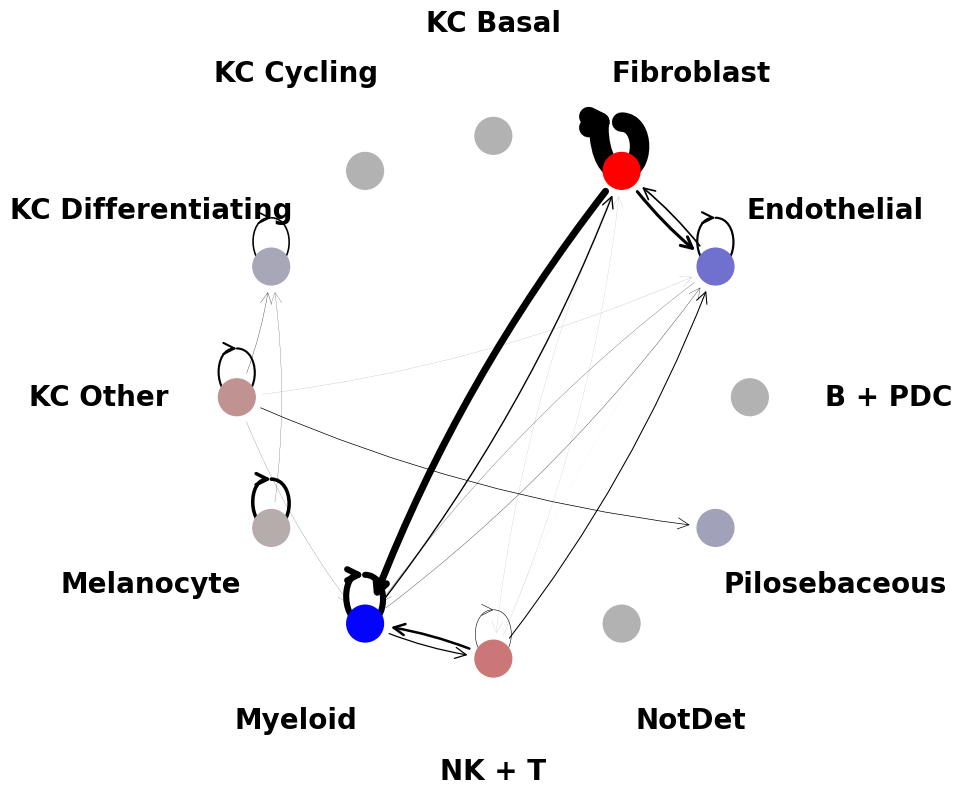

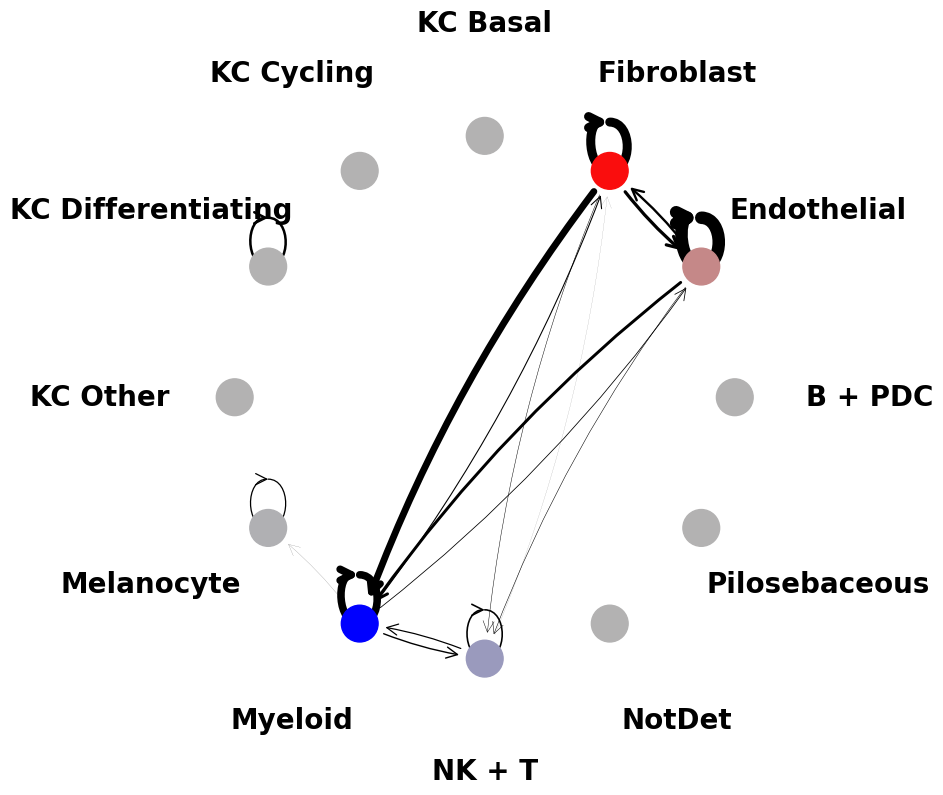

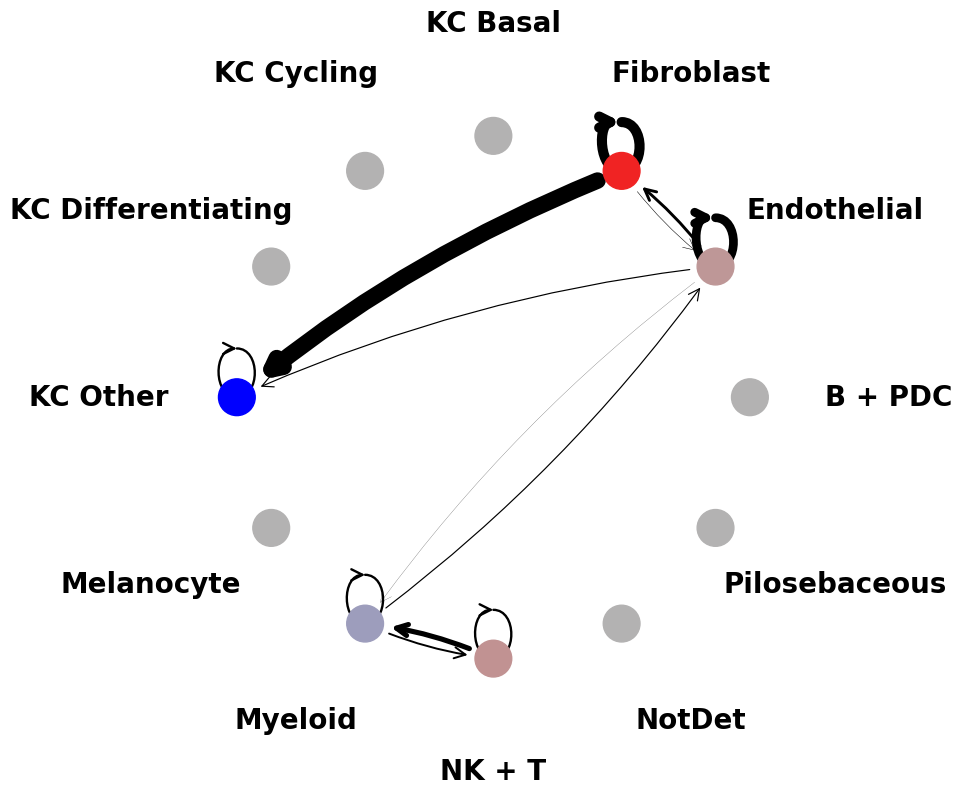

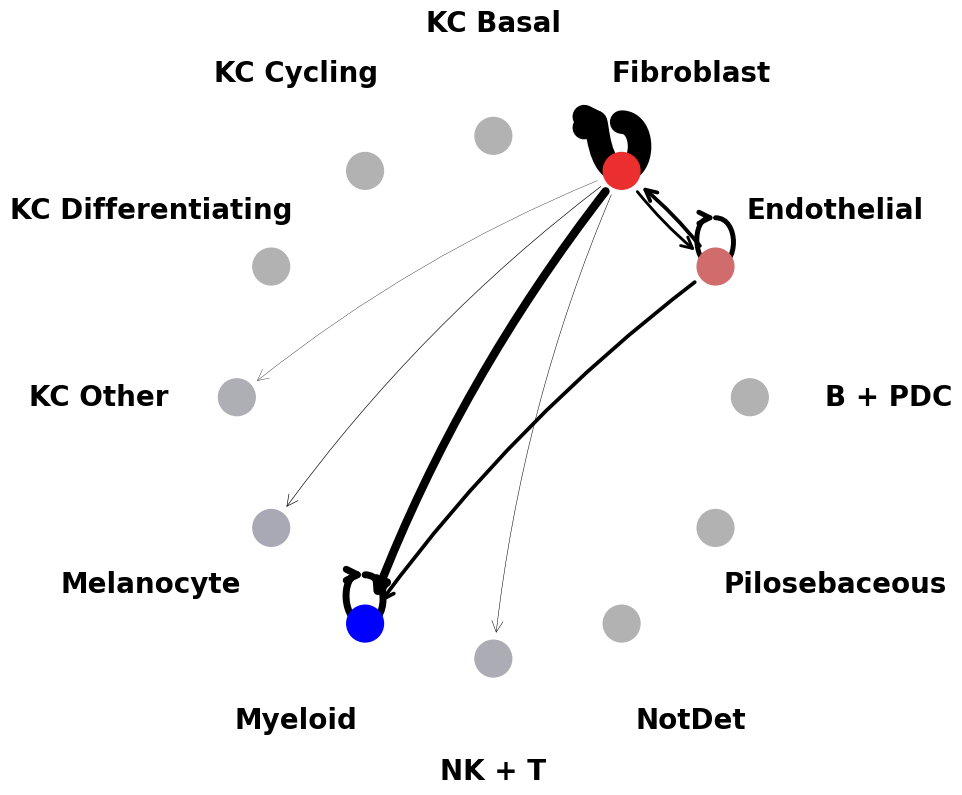

In [10]:
patient_integrated = {}

for patient, samples in patients.items():
    for tech in patients[patient].keys():
        if len(samples[tech]) >= 2:
            samples[tech] = mmcci.it.integrate_samples(samples[tech])
        else:
            samples[tech] = samples[tech][0]
    normalised = mmcci.it.normalise_between_tech([samples['vis'], samples['cos']])
    integrated = mmcci.it.integrate_samples(normalised)
    overall = mmcci.it.calculate_overall_interactions(integrated)
    mmcci.plt.network_plot(overall, edge_weight=40, text_size=20, node_label_dist=1.1)
    patient_integrated[patient] = integrated

We can then integrate all the patients together as well

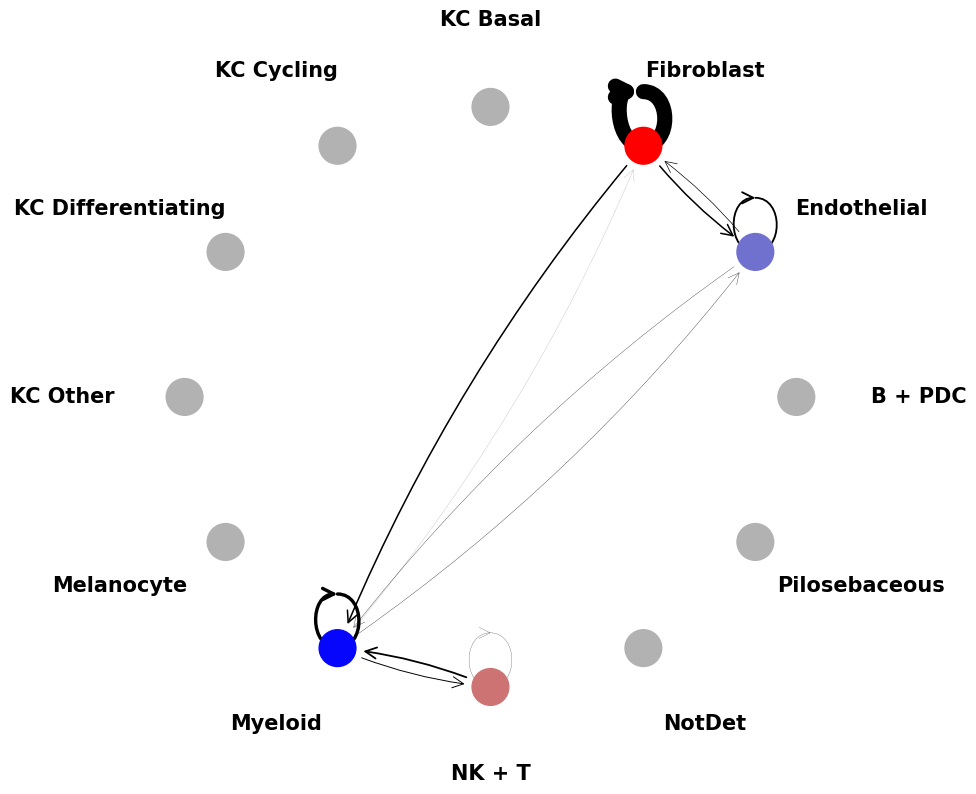

In [11]:
normalised = mmcci.it.normalise_between_tech(
    [patient_integrated['6747'], patient_integrated['21031'], patient_integrated['48974'], patient_integrated['66487']]
    )

integrated = mmcci.it.integrate_samples(normalised)
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.network_plot(overall)

## **Analysis**

Here we will have a look deeper into some specific interactions relevant to the disease

#### Get LR pairs and pathways from fibroblasts to endothelial cells for each patient

Patient: 6747


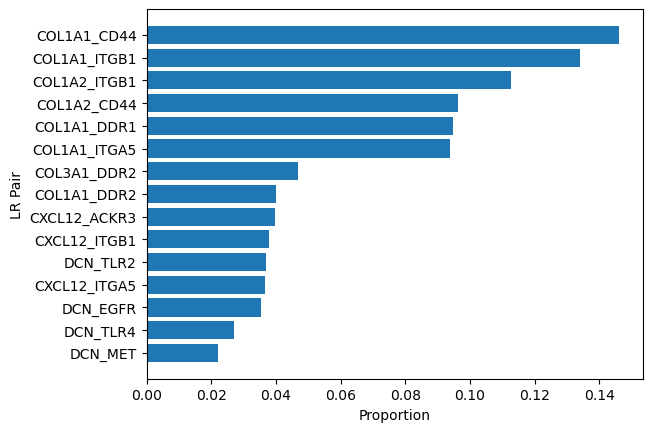

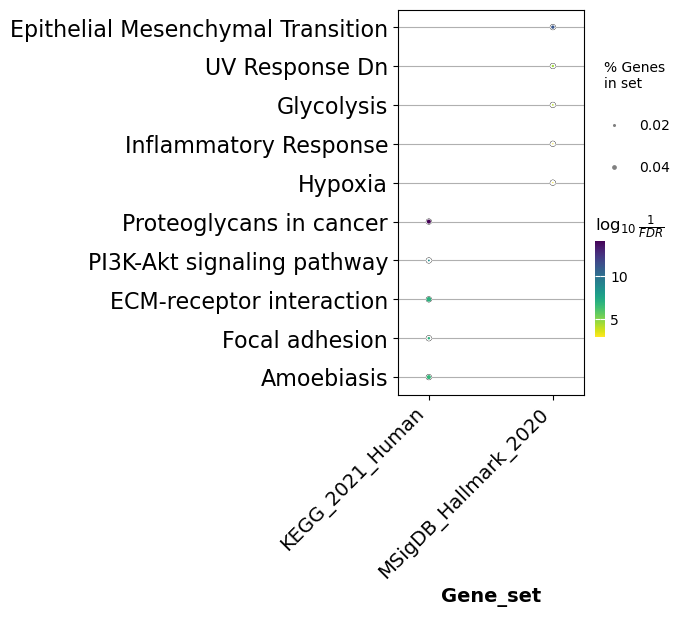

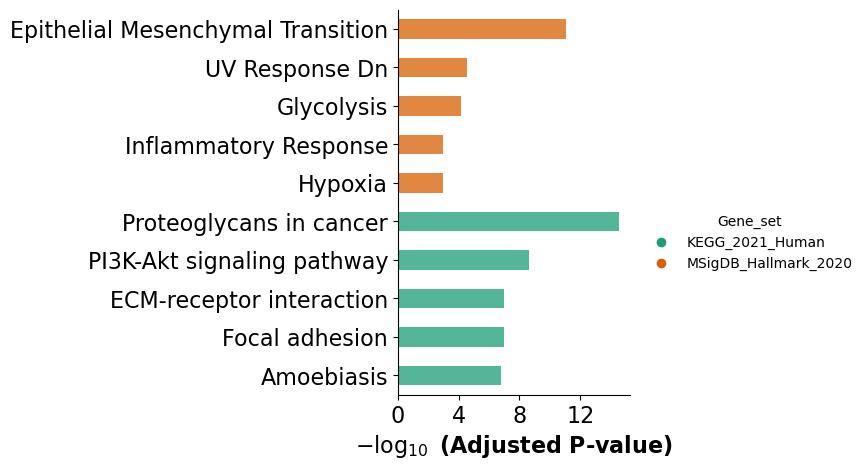

Patient: 21031


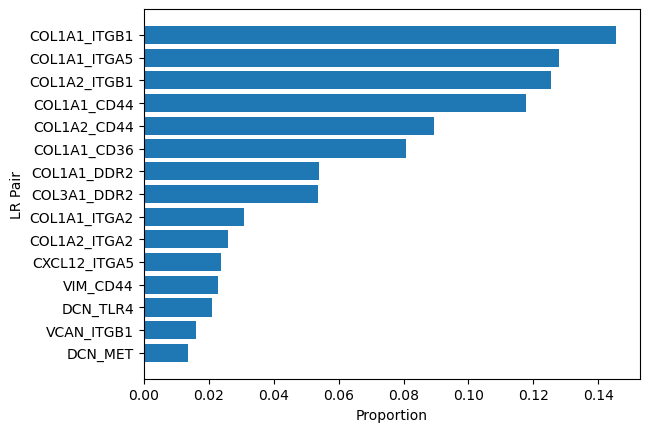

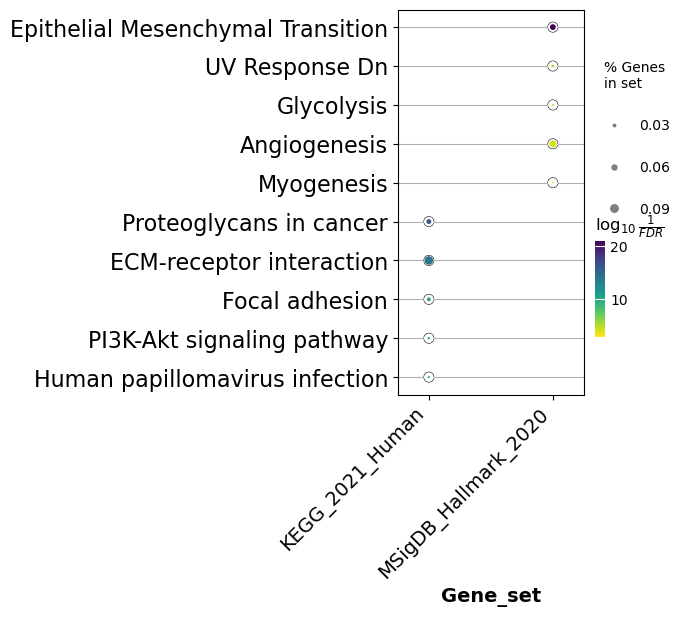

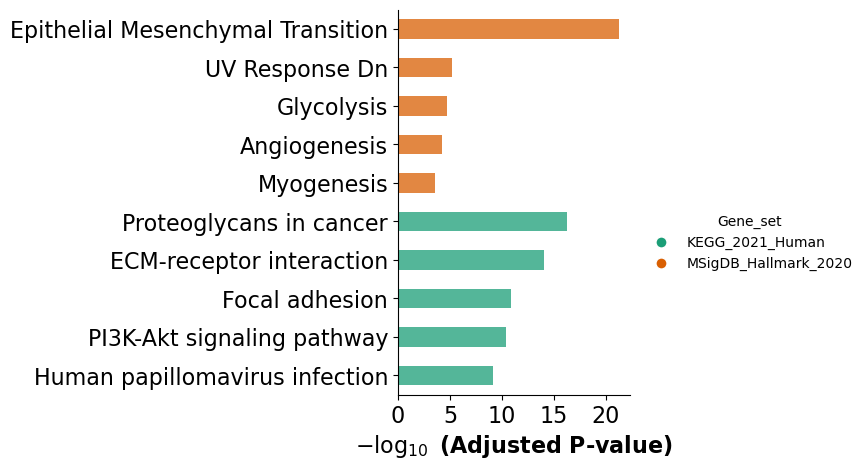

Patient: 48974


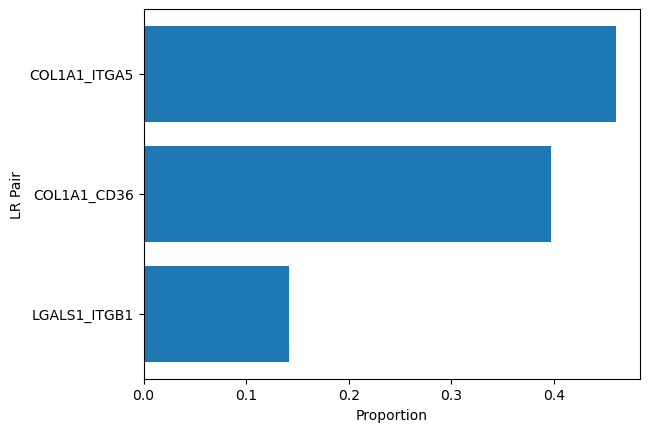

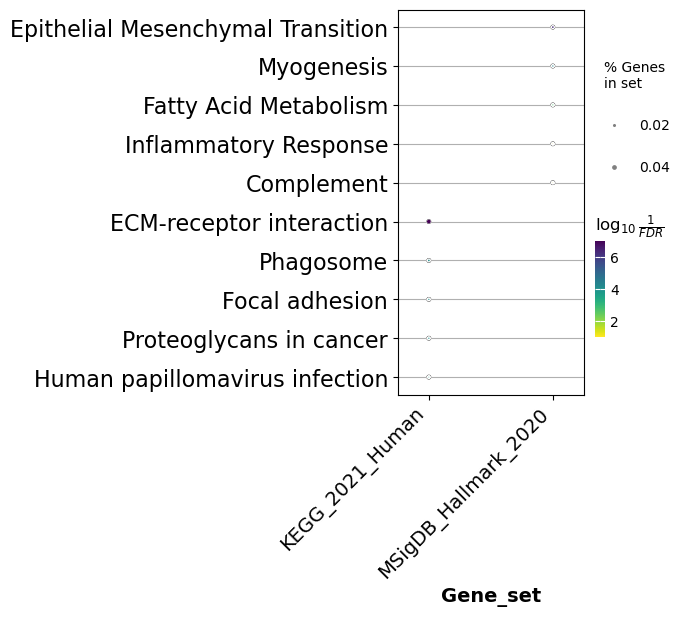

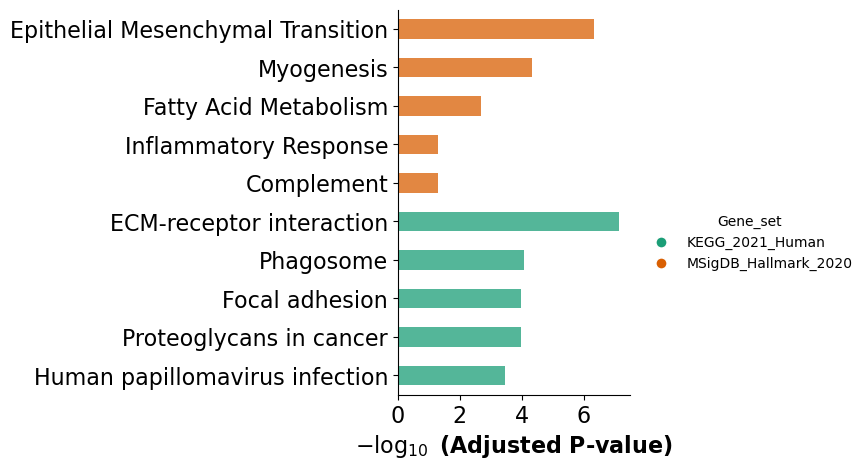

Patient: 66487


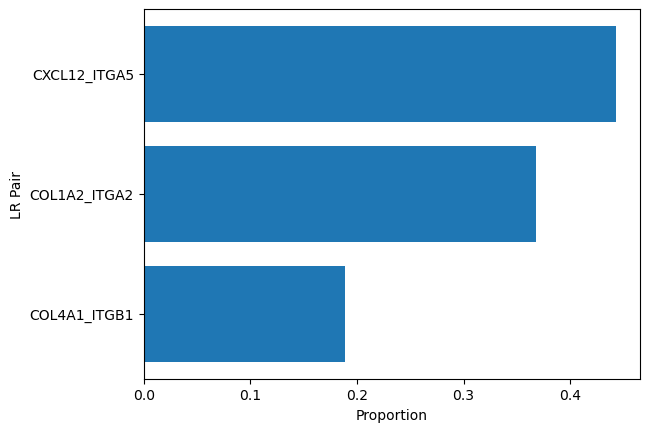

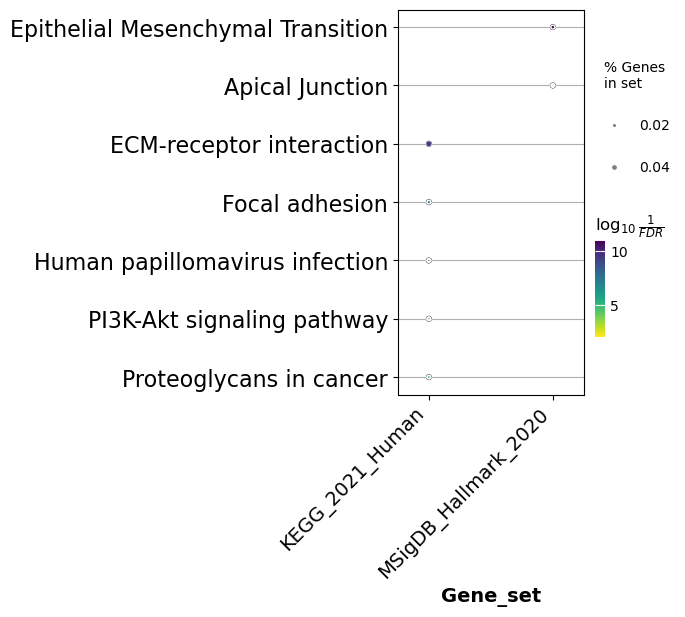

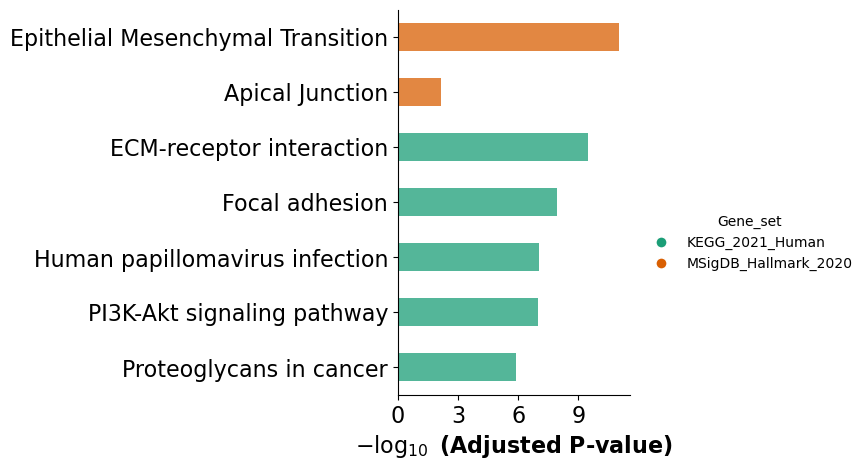

In [22]:
for name, patient in patient_integrated.items():
    print(f"Patient: {name}")
    mmcci.plt.lrs_per_celltype(patient, "Fibroblast", "Endothelial")
    mmcci.an.run_gsea(patient, mmcci.an.get_lrs_per_celltype(patient, "Fibroblast", "Endothelial"))
    plt.show()